In [1]:
# Set up CUDA in OS
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'
# Import libabries
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
import seaborn as sn
import pandas as pd
import torchvision
from torchvision import *
from torch.utils.data import Dataset, DataLoader
from torchvision.io import read_image
import torchvision.transforms as T
from torchvision import datasets, models, transforms
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

import matplotlib.pyplot as plt
import time
import copy

# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

In [2]:
# Check version of Pytorch
print(torch. __version__)

1.10.0


In [3]:
# Setup device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [4]:
train_dir = "../../../DataSet/Transformed - DMR - Database For Mastology Research - Visual Lab/train"
test_dir = "../../../DataSet/Transformed - DMR - Database For Mastology Research - Visual Lab/test"

In [5]:
model_googlenet = models.googlenet(pretrained=True)
model_googlenet

GoogLeNet(
  (conv1): BasicConv2d(
    (conv): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (conv2): BasicConv2d(
    (conv): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv3): BasicConv2d(
    (conv): Conv2d(64, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(192, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (inception3a): Inception(
    (branch1): BasicConv2d(
      (conv): Conv2d(192, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track

In [6]:
num_features = model_googlenet.fc.in_features 
print('Number of features from pre-trained model', num_features)

Number of features from pre-trained model 1024


In [7]:
# Add a fully-connected layer for classification
model_googlenet.fc = nn.Linear(num_features, 2)
model_googlenet = model_googlenet.to(device)

In [8]:
# Define loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model_googlenet.parameters(), lr=0.0001, momentum=0.9)

In [9]:
# Set the random seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)

In [10]:
# Create transform function
transforms_train = transforms.Compose([
    transforms.Resize((224, 224)),   #must same as here
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(), # data augmentation
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) # normalization
])
transforms_test = transforms.Compose([
    transforms.Resize((224, 224)),   #must same as here
     transforms.CenterCrop((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

In [11]:
# Apply for training and test data
train_dataset = datasets.ImageFolder(train_dir, transforms_train)
test_dataset = datasets.ImageFolder(test_dir, transforms_test)

train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=12, shuffle=True, num_workers=0)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=12, shuffle=False, num_workers=0)

In [12]:
#### Train model
train_loss=[]
train_accuary=[]
test_loss=[]
test_accuary=[]

num_epochs = 30   #(set no of epochs)
start_time = time.time() #(for showing time)
# Start loop
for epoch in range(num_epochs): #(loop for every epoch)
    print("Epoch {} running".format(epoch)) #(printing message)
    """ Training Phase """
    model_googlenet.train()    #(training model)
    running_loss = 0.   #(set loss 0)
    running_corrects = 0 
    # load a batch data of images
    for i, (inputs, labels) in enumerate(train_dataloader):
        inputs = inputs.to(device)
        labels = labels.to(device) 
        # forward inputs and get output
        optimizer.zero_grad()
        outputs = model_googlenet(inputs)
        _, preds = torch.max(outputs, 1)
        loss = criterion(outputs, labels)
        # get loss value and update the network weights
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        running_corrects += torch.sum(preds == labels.data).item()
    epoch_loss = running_loss / len(train_dataset)
    epoch_acc = running_corrects / len(train_dataset) * 100.
    # Append result
    train_loss.append(epoch_loss)
    train_accuary.append(epoch_acc)
    # Print progress
    print('[Train #{}] Loss: {:.4f} Acc: {:.4f}% Time: {:.4f}s'.format(epoch+1, epoch_loss, epoch_acc, time.time() -start_time))
    """ Testing Phase """
    model_googlenet.eval()
    with torch.no_grad():
        running_loss = 0.
        running_corrects = 0
        for inputs, labels in test_dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model_googlenet(inputs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)
            running_loss += loss.item()
            running_corrects += torch.sum(preds == labels.data).item()
        epoch_loss = running_loss / len(test_dataset)
        epoch_acc = running_corrects / len(test_dataset) * 100.
        # Append result
        test_loss.append(epoch_loss)
        test_accuary.append(epoch_acc)
        # Print progress
        print('[Test #{}] Loss: {:.4f} Acc: {:.4f}% Time: {:.4f}s'.format(epoch+1, epoch_loss, epoch_acc, time.time()- start_time))

save_path = 'models/breast_thermo_cancer-classifier_googlenet_final.pth'
torch.save(model_googlenet.state_dict(), save_path)

Epoch 0 running
[Train #1] Loss: 0.0473 Acc: 73.7086% Time: 1429.8832s
[Test #1] Loss: 0.0465 Acc: 75.2941% Time: 1588.2514s
Epoch 1 running
[Train #2] Loss: 0.0452 Acc: 75.8105% Time: 2506.9126s
[Test #2] Loss: 0.0448 Acc: 75.2941% Time: 2651.9816s
Epoch 2 running
[Train #3] Loss: 0.0441 Acc: 75.8105% Time: 3572.3942s
[Test #3] Loss: 0.0441 Acc: 75.2941% Time: 3716.6315s
Epoch 3 running
[Train #4] Loss: 0.0432 Acc: 75.7748% Time: 4643.4607s
[Test #4] Loss: 0.0418 Acc: 75.2941% Time: 4787.9846s
Epoch 4 running
[Train #5] Loss: 0.0416 Acc: 76.1667% Time: 5710.1724s
[Test #5] Loss: 0.0401 Acc: 75.2941% Time: 5856.3261s
Epoch 5 running
[Train #6] Loss: 0.0403 Acc: 76.4874% Time: 6779.4694s
[Test #6] Loss: 0.0386 Acc: 75.4622% Time: 6925.5769s
Epoch 6 running
[Train #7] Loss: 0.0396 Acc: 77.1642% Time: 7847.5720s
[Test #7] Loss: 0.0362 Acc: 76.8908% Time: 7993.2588s
Epoch 7 running
[Train #8] Loss: 0.0383 Acc: 78.1261% Time: 8920.2005s
[Test #8] Loss: 0.0348 Acc: 79.1597% Time: 9065.4550s


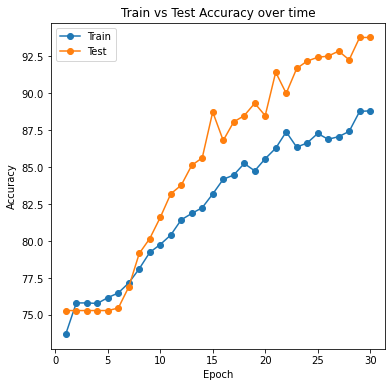

In [13]:
# Plot
plt.figure(figsize=(6,6))
plt.plot(np.arange(1,num_epochs+1), train_accuary,'-o')
plt.plot(np.arange(1,num_epochs+1), test_accuary,'-o')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train','Test'])
plt.title('Train vs Test Accuracy over time')
plt.show()

In [14]:
# Get data to check on the performance of each label
y_pred = []
y_true = []


num_epochs = 30   #(set no of epochs)
start_time = time.time() #(for showing time)
# Start loop
for epoch in range(num_epochs): #(loop for every epoch)
    model_googlenet.eval()
    with torch.no_grad():
        for inputs, labels in test_dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model_googlenet(inputs) # Feed Network
            outputs = (torch.max(torch.exp(outputs), 1)[1]).data.cpu().numpy()
            y_pred.extend(outputs) # Save Prediction
            labels = labels.data.cpu().numpy()
            y_true.extend(labels) # Save Truth

Accuracy on Training set:  0.9378151260504202
Confusion matrix: 
 [[26340   540]
 [ 1680  7140]]
Classification report: 
               precision    recall  f1-score   support

           0       0.94      0.98      0.96     26880
           1       0.93      0.81      0.87      8820

    accuracy                           0.94     35700
   macro avg       0.93      0.89      0.91     35700
weighted avg       0.94      0.94      0.94     35700



<AxesSubplot:title={'center':'Confusion matrix for Breast Cancer classification '}>

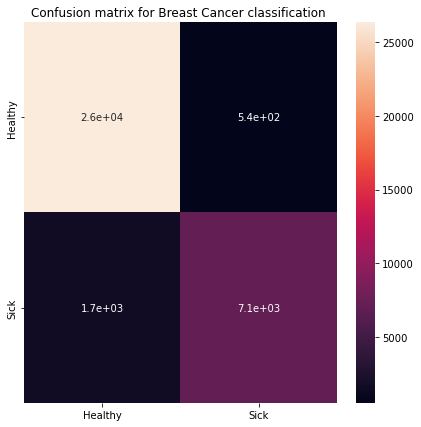

In [15]:
# Visualization and result
# constant for classes
classes = test_dataset.classes
# Build confusion matrix
print("Accuracy on Training set: ",accuracy_score(y_true, y_pred))
print('Confusion matrix: \n', confusion_matrix(y_true, y_pred))
print('Classification report: \n', classification_report(y_true, y_pred))
# Plot
cf_matrix = confusion_matrix(y_true, y_pred)
df_cm = pd.DataFrame(cf_matrix, index = [i for i in classes], columns = [i for i in classes])
plt.figure(figsize = (7,7))
plt.title("Confusion matrix for Breast Cancer classification ")
sn.heatmap(df_cm, annot=True)

# Load your saved model

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
#import seaborn as sn
import pandas as pd
import torchvision
from torchvision import *
from torch.utils.data import Dataset, DataLoader
from torchvision.io import read_image
import torchvision.transforms as T
from torchvision import datasets, models, transforms
#from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model_resnet50 = models.resnet50(pretrained=True)
num_features = model_resnet50.fc.in_features 
# Add a fully-connected layer for classification
model_resnet50.fc = nn.Linear(num_features, 2)
model_resnet50 = model_resnet50.to(device)
# Define loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model_resnet50.parameters(), lr=0.0001, momentum=0.9)
# Set the random seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)

model_resnet50.load_state_dict(torch.load('models/breast_thermo_cancer-classifier_resnet_50_final.pth'))